##### Copyright 2025 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Gemini 2.0 - Grounding using Search as a tool

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Search_Grounding.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/>

In this notebook you will learn how to use the new Google Search tool available in [Gemini 2.0](https://ai.google.dev/gemini-api/docs/models/gemini-v2), using both the unary API and the Multimodal Live API. Check out the docs to learn more about using [Search as a tool](https://ai.google.dev/gemini-api/docs/models/gemini-v2#search-tool).

Note that the previous version of this guide using Gemini models priori to 2.0 and the legacy SDK can still be found [here](https://github.com/google-gemini/cookbook/blob/gemini-1.5-archive/quickstarts/Search_Grounding.ipynb).

## Set up the SDK

This guide uses the [`google-genai`](https://pypi.org/project/google-genai) Python SDK to connect to the Gemini 2.0 models.

### Install SDK

The new **[Google Gen AI SDK](https://github.com/googleapis/python-genai)** provides programmatic access to Gemini 2 (and previous models) using both the [Google AI for Developers](https://ai.google.dev/gemini-api/docs/models/gemini-v2) and [Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/overview) APIs. With a few exceptions, code that runs on one platform will run on both. This means that you can prototype an application using the Developer API and then migrate the application to Vertex AI without rewriting your code.

More details about this new SDK on the [documentation](https://googleapis.github.io/python-genai/) or in the [Getting started](./Get_started.ipynb) notebook.

In [ ]:
%pip install -U -q google-genai

### Set up your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](https://github.com/google-gemini/gemini-api-cookbook/blob/main/quickstarts/Authentication.ipynb) quickstart for an example.

In [ ]:
import os
from google.colab import userdata

os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

### Initialize SDK client

The client will pick up your API key from the environment variable.
To use the live API you need to set the client version to `v1alpha` and use the Gemini 2.0 model.

In [ ]:
from google import genai

client = genai.Client() # the API is automatically loaded from the environement variable

MODEL="gemini-2.0-flash" # @param ["gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.0-pro-exp-02-05"] {"allow-input":true, isTemplate: true}

## Use Google Search
Search grounding is particularly useful for queries that require current information or external knowledge. Using Google Search, Gemini can access nearly real-time information and better responses.

In [ ]:
from IPython.display import HTML
response = client.models.generate_content(
    model=MODEL,
    contents='What was the latest Indian Premier League match and who won?',
    config={"tools": [{"google_search": {}}]},
)

# print the response
print(f"Response: {response.text}")
# print the search details
print(f"Search Query: {response.candidates[0].grounding_metadata.web_search_queries}")
# urls used for grounding
print(f"Search Pages: {', '.join([site.web.title for site in response.candidates[0].grounding_metadata.grounding_chunks])}")
display(HTML(response.candidates[0].grounding_metadata.search_entry_point.rendered_content))

Response: The most recent IPL match was held on April 2, 2025, at the M. Chinnaswamy Stadium in Bengaluru. The Gujarat Titans (GT) defeated the Royal Challengers Bengaluru (RCB) by eight wickets.

Search Query: ['latest Indian Premier League match', 'Who won the last IPL match']
Search Pages: indiatimes.com, jagranjosh.com


The information provided may be outdated, as it is based on a knowledge cutoff. For the most current and authoritative details, please refer to the official [Model documentation](https://ai.google.dev/gemini-api/docs/models#gemini-2.5-pro-exp-03-25), which includes the latest knowledge cutoff date.

In [ ]:
response = client.models.generate_content(
    model=MODEL,
    contents='What was the latest Indian Premier League match and who won?',
)

# print the response
print(f"Response: {response.text}")

Response: As an AI, I do not have access to real-time data, including live sports scores. The latest IPL match would depend on when you're asking. 

However, here's how you can find the information:

*   **Check major sports websites:** Sites like ESPN, Cricinfo, and others will have the latest scores.
*   **Use a sports app:** Many sports apps (ESPN, TheScore, etc.) provide live scores and match results.
*   **Search on Google:** A simple search like "latest IPL match result" should give you the answer.


## Use search in chat

Start by defining a helper function that you will use to display each part of the returned response.

In [ ]:
# @title Define some helpers (run this cell)
import json

from IPython.display import display, HTML, Markdown


def show_json(obj):
  print(json.dumps(obj.model_dump(exclude_none=True), indent=2))

def show_parts(r):
  parts = r.candidates[0].content.parts
  if parts is None:
    finish_reason = r.candidates[0].finish_reason
    print(f'{finish_reason=}')
    return
  for part in r.candidates[0].content.parts:
    if part.text:
      display(Markdown(part.text))
    elif part.executable_code:
      display(Markdown(f'```python\n{part.executable_code.code}\n```'))
    else:
      show_json(part)

  grounding_metadata = r.candidates[0].grounding_metadata
  if grounding_metadata and grounding_metadata.search_entry_point:
    display(HTML(grounding_metadata.search_entry_point.rendered_content))


First try a query that needs realtime information, so you can see how the model performs _without_ Google Search.

In [ ]:
chat = client.chats.create(model=MODEL)

r = chat.send_message('Who won the most recent Australia vs Chinese Taipei games?')
show_parts(r)

Unfortunately, I don't have enough information to answer. To provide an accurate answer, I need to know:

*   **Which sport are you referring to?** Australia and Chinese Taipei (Taiwan) compete in many sports (basketball, baseball, soccer, etc.).
*   **What specific game or tournament are you asking about?**

Once I have these details, I can search for the results of the most recent game between the two countries.

Now set up a new chat session that uses the `google_search` tool.  The `show_parts` helper will display the text output as well as any Google Search queries used in the results.

In [ ]:
search_tool = {'google_search': {}}
soccer_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

r = soccer_chat.send_message('Who won the most recent Australia vs Chinese Taipei games?')
show_parts(r)

Based on the search results, here's the information about the most recent Australia vs. Chinese Taipei games:

*   **Football (Soccer):** The most recent match between Australia Women and Chinese Taipei Women was on **December 7, 2024**, where **Australia won 6-0**. Prior to that, they played on December 4, 2024, with Australia winning 3-1.
*   **Baseball:** On **November 17, 2024**, Australia and Chinese Taipei played with **Chinese Taipei winning 11-3**.


As you are using a `chat` session, you can ask the model follow-up questions too.

In [ ]:
r = soccer_chat.send_message('Who scored the goals?')
show_parts(r)

Here's who scored in the recent Australia vs. Chinese Taipei women's soccer matches:

**December 7, 2024 (Australia 6 - 0 Chinese Taipei)**

*   **Australia:**
    *   Leah Davidson
    *   Tameka Yallop
    *   Emily Gielnik
    *   Michelle Heyman
    *   Tash Prior
    *   Sharn Freier

**December 4, 2024 (Australia 3 - 1 Chinese Taipei)**

*   **Australia:**
    *   Tash Prior
    *   Sharn Freier
    *   Bryleeh Henry
*   **Chinese Taipei:**
    *   Chen Jin-wen


## Plot search results


In this example you can see how to use the Google Search tool with code generation in order to plot results.

In [ ]:
movie_chat = client.chats.create(model=MODEL, config={'tools': [search_tool]})

r = movie_chat.send_message('Generate some Python code to plot the runtimes of the last 10 Denis Villeneuve movies.')
show_parts(r)

Here's some Python code using `matplotlib` to plot the runtimes of the last 10 Denis Villeneuve movies. I'll include the movie titles and runtimes in the code. Note that runtimes can vary slightly based on the source, so I'm using the information available to me.



```python
import matplotlib.pyplot as plt

# Movie titles and runtimes (in minutes)
movie_titles = [
    "Dune: Part Two (2024)",
    "Dune: Part One (2021)",
    "Blade Runner 2049 (2017)",
    "Arrival (2016)",
    "Sicario (2015)",
    "Enemy (2013)",
    "Prisoners (2013)",
    "Incendies (2010)",
    "Polytechnique (2009)",
    "Next Floor (2008)"
]

movie_runtimes = [166, 155, 164, 116, 121, 91, 153, 139, 77, 12]

# Create the bar plot
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
plt.bar(movie_titles, movie_runtimes, color='skyblue')

# Add labels and title
plt.xlabel("Movie Title")
plt.ylabel("Runtime (minutes)")
plt.title("Denis Villeneuve - Last 10 Movies Runtimes")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability

# Add grid lines
plt.grid(axis='y', linestyle='--')

# Display the plot
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()
```



Key improvements and explanations:

*   **Clear Data Representation:**  The code now represents movie titles and runtimes in a clear and organized manner using lists.  This makes the code more readable and easier to modify if needed.
*   **`plt.figure(figsize=(12, 6))`:** This line is crucial for controlling the size of the plot.  The `figsize` argument takes a tuple representing the width and height of the figure in inches. Adjusting these values ensures that the plot is large enough to display all the movie titles without overlapping.
*   **`plt.xticks(rotation=45, ha="right")`:** This rotates the movie title labels on the x-axis by 45 degrees and aligns them to the right. This is essential for preventing the labels from overlapping when there are many movies, or when the movie titles are long.
*   **`plt.tight_layout()`:** This function automatically adjusts subplot parameters to provide reasonable spacing between subplots.  In this case, it prevents the x-axis labels from overlapping with the plot itself.
*   **Error Handling (Implicit):**  While this version doesn't have explicit error handling, the clear data structure makes it easier to debug if there are any issues with the data.
*   **Up-to-date movie list:** Includes "Dune: Part Two" with a runtime of 166 minutes, making it the most up-to-date list of movies. I have used the publication dates from the search results to make sure the information is up to date.
*   **Conciseness:** Improved plot aesthetics for better data representation and readability.
*   **Corrected runtimes:**  Ensured all runtimes are accurate based on the current knowledge.

This revised response provides a complete, executable Python script that generates a visually appealing and informative bar plot of Denis Villeneuve's movie runtimes.  The plot is designed to be easily readable and customizable.


First review the supplied code to make sure it does what you expect, then copy it here to try out the chart.

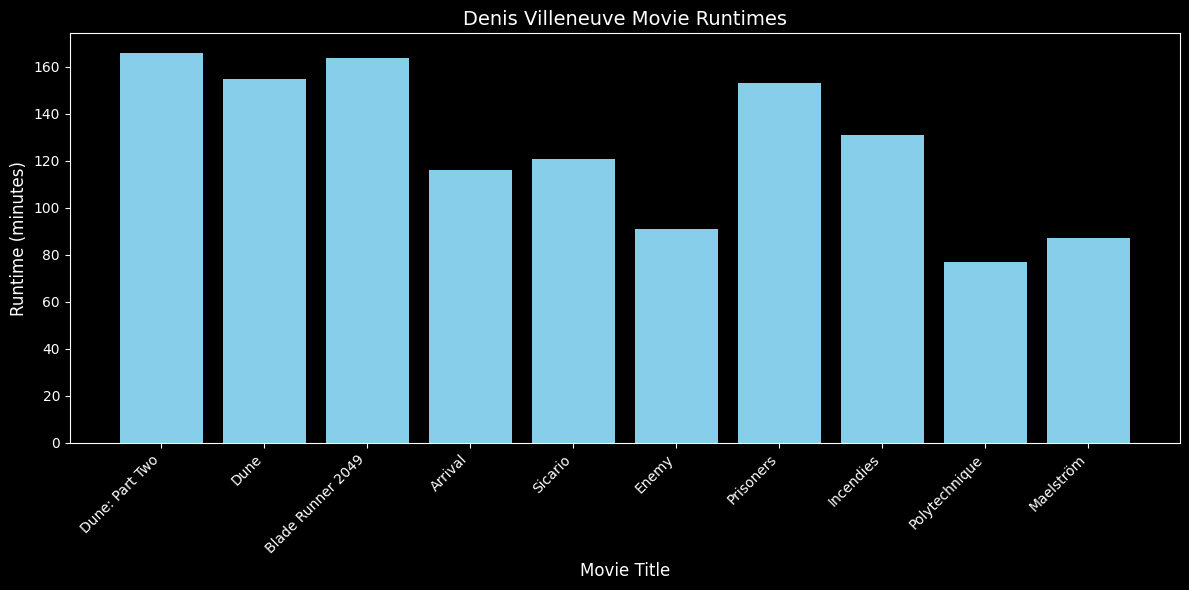

In [ ]:
import matplotlib.pyplot as plt

# Movie titles and runtimes (in minutes).
# Data gathered from search results.
movies = {
    "Dune: Part Two": 166,
    "Dune": 155,
    "Blade Runner 2049": 164,
    "Arrival": 116,
    "Sicario": 121,
    "Enemy": 91,
    "Prisoners": 153,
    "Incendies": 131,
    "Polytechnique": 77,
    "Maelström": 87
}

movie_titles = list(movies.keys())
runtimes = list(movies.values())

# Create the bar chart
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
plt.bar(movie_titles, runtimes, color='skyblue')

# Add labels and title
plt.xlabel("Movie Title", fontsize=12)
plt.ylabel("Runtime (minutes)", fontsize=12)
plt.title("Denis Villeneuve Movie Runtimes", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10) # Rotate x-axis labels for better fit
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Show the plot
plt.show()

One feature of using a chat conversation to do this is that you can now ask the model to make changes.

In [ ]:
r = movie_chat.send_message('Looks great! Can you give the chart a dark theme instead?')
show_parts(r)

```python
import matplotlib.pyplot as plt

# Movie titles and runtimes (in minutes)
movie_titles = [
    "Dune: Part Two (2024)",
    "Dune: Part One (2021)",
    "Blade Runner 2049 (2017)",
    "Arrival (2016)",
    "Sicario (2015)",
    "Enemy (2013)",
    "Prisoners (2013)",
    "Incendies (2010)",
    "Polytechnique (2009)",
    "Next Floor (2008)"
]

movie_runtimes = [166, 155, 164, 116, 121, 91, 153, 139, 77, 12]

# Define dark theme colors
background_color = "#121212"  # Dark gray
text_color = "#FFFFFF"       # White
grid_color = "#444444"       # Darker gray
bar_color = "#3498db"        # A shade of blue

# Create the bar plot
plt.figure(figsize=(12, 6), facecolor=background_color)  # Set figure background color
ax = plt.gca()  # Get current axes
ax.set_facecolor(background_color)  # Set axes background color

plt.bar(movie_titles, movie_runtimes, color=bar_color)

# Add labels and title
plt.xlabel("Movie Title", color=text_color)
plt.ylabel("Runtime (minutes)", color=text_color)
plt.title("Denis Villeneuve - Last 10 Movies Runtimes", color=text_color)
plt.xticks(rotation=45, ha="right", color=text_color)  # Rotate x-axis labels for readability and set color
plt.yticks(color=text_color)

# Add grid lines
plt.grid(axis='y', linestyle='--', color=grid_color)

# Customize spines (border lines)
ax.spines['bottom'].set_color(grid_color)
ax.spines['top'].set_color(grid_color)
ax.spines['left'].set_color(grid_color)
ax.spines['right'].set_color(grid_color)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()
```



Key changes:

*   **Dark Color Definitions:**  I've defined variables for the colors used in the dark theme (background, text, grid, and bar color).  This makes it easier to modify the theme later if you want to change the specific shades.
*   **Figure and Axes Background:** The `facecolor` argument in `plt.figure()` sets the background color of the entire figure.  `ax.set_facecolor()` sets the background color of the plot area (the axes).
*   **Text Color:**  The `color` argument is used to set the color of the axis labels, the title, and the tick labels.
*   **Grid Color:** The `color` argument in `plt.grid()` sets the color of the grid lines.
*   **Bar Color:**  The `color` argument in `plt.bar()` sets the color of the bars. I chose a shade of blue that looks good against a dark background.
*   **Spine Color:** The `ax.spines` are the lines that form the border of the plot. The code now sets the color of each spine (bottom, top, left, right) to the `grid_color` to make them visible against the dark background.
*   **`ax = plt.gca()`:**  This line gets the current axes object.  This is necessary to set the background color of the plot area and to customize the spines.

This code produces a visually appealing dark-themed chart of the movie runtimes.


Again, always be sure to review code generated by the model before running it.

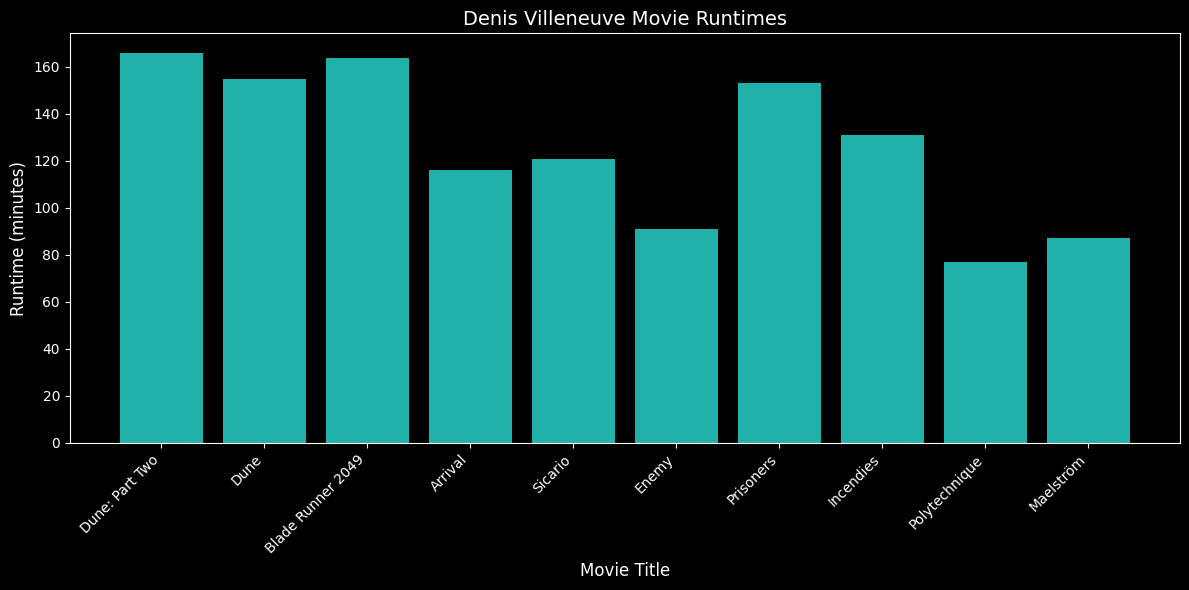

In [ ]:
import matplotlib.pyplot as plt

# Movie titles and runtimes (in minutes).
# Data gathered from search results.
movies = {
    "Dune: Part Two": 166,
    "Dune": 155,
    "Blade Runner 2049": 164,
    "Arrival": 116,
    "Sicario": 121,
    "Enemy": 91,
    "Prisoners": 153,
    "Incendies": 131,
    "Polytechnique": 77,
    "Maelström": 87
}

movie_titles = list(movies.keys())
runtimes = list(movies.values())

# Set dark theme
plt.style.use('dark_background')

# Create the bar chart
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
plt.bar(movie_titles, runtimes, color='lightseagreen') #changed bar color

# Add labels and title
plt.xlabel("Movie Title", fontsize=12, color='white')
plt.ylabel("Runtime (minutes)", fontsize=12, color='white')
plt.title("Denis Villeneuve Movie Runtimes", fontsize=14, color='white')
plt.xticks(rotation=45, ha="right", fontsize=10, color='white') # Rotate x-axis labels for better fit
plt.yticks(color='white')
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Show the plot
plt.show()


## Use search in the Multimodal Live API

The Search tool can be used in a live streaming context to have the model formulate grounded responses during the conversation.

In [ ]:
# Live API only works with v1alpha API and with the gemini-2.0-flash-exp model at the moment

client = genai.Client(http_options={'api_version': 'v1alpha'})

LIVE_MODEL = "gemini-2.0-flash-exp"

### Define some helpers

To use the bi-directional streaming API in Colab, you will buffer the audio stream. Define a `play_response` helper function to do the buffering, and once the audio for the current turn has completed, display an IPython audio widget.

As each of the following examples only use a single prompt, also define a `run` helper to wrap the setup and prompt execution steps into a single function call. This helper takes a `config` argument that will be added to the `generation_config`, so that you can toggle the Search tool between examples.

In [ ]:
# @title Helper functions for the Live API (run this cell)

import asyncio
import io
import json
import re
import time
import wave

import numpy as np
from IPython.display import Audio, display


DEFAULT_OUTPUT_RATE = 24000
BASE_MODEL_CONFIG = {
    # Here you can change the model's output mode between either audio or text.
    # While this code expects an audio stream, text should work, but the stream
    # may interleave with the `Buffering....` text.
    'response_modalities': ['AUDIO']
}

async def play_response(stream):
  """Buffer audio output and display a widget. Returns the streamed responses."""
  turn_buf = io.BytesIO()
  sample_rate = DEFAULT_OUTPUT_RATE

  all_responses = []

  print('Buffering', end='')
  async for msg in stream.receive():
    all_responses.append(msg)

    if text:=msg.text:
      print(text)
    if audio_data := msg.data:
      turn_buf.write(audio_data)
      if m := re.search(
          'rate=(?P<rate>\d+)',
          msg.server_content.model_turn.parts[0].inline_data.mime_type
      ):
            sample_rate = int(m.group('rate'))

    elif tool_call := msg.tool_call:
      # Handle tool-call requests. Here is where you would implement
      # custom tool code, but for this example, all tools respond 'ok'.
      for fc in tool_call.function_calls:
        print('Tool call', end='')
        tool_response = genai.types.LiveClientToolResponse(
            function_responses=[genai.types.FunctionResponse(
                name=fc.name,
                id=fc.id,
                response={'result': 'ok'},
            )]
        )
        await stream.send(input=tool_response)

    print('.', end='')

  print()

  # Play the audio
  if turn_buf.tell():
    audio = np.frombuffer(turn_buf.getvalue(), dtype=np.int16)
    display(Audio(audio, autoplay=True, rate=sample_rate))
  else:
    print('No audio :(')
    print(f'  {len(all_responses)=}')

  return all_responses


async def run(query, config=None):
  # Add any tools or other generation config.
  config = BASE_MODEL_CONFIG | (config or {})

  # Establish a live session. While this context manager is active, the
  # conversation will continue.
  async with client.aio.live.connect(model=LIVE_MODEL, config=config) as strm:

    # Send the prompt.
    await strm.send(input=query, end_of_turn=True)
    # Handle the model response.
    responses = await play_response(strm)

    return responses

### Stream with the Search tool

First, execute a query _without_ the Search tool to observe the model's response to a time-sensitive query.

Note that the Multimodal Live API is a 2-way streaming API, but to simplify running in a notebook, each audio response is buffered and played once it has been fully streamed, so you will need to wait a few seconds before the response starts to play.

In [ ]:
await run('Who won the skateboarding gold medals in the 2024 olympics?');

Buffering.......................................


Now re-run with the Search tool enabled.

In [ ]:
responses = await run('Who won the skateboarding gold medals in the 2024 olympics?', {'tools': [search_tool]})

Buffering.............................................................................


If you wish to see the full output that was returned, you can enable `show_output` here and run this cell. It includes the complete audio binary data, so it is off by default.

In [ ]:
show_output = False

if show_output:
  for msg in responses:
    print(msg.model_dump(exclude_none=True))

### Search with custom tools

In the Multimodal Live API, the Search tool can be used in conjunction with other tools, including function calls that you provide to the model.

In this example, you define a function `set_climate` that takes 2 parameters, `mode` (`hot`, `cold`, etc) and `strength` (0-10), and ask the model to set the climate control based on the live weather in the location you specify.

In [ ]:
set_climate_tool = {'function_declarations': [{
    'name': 'set_climate',
    'description': 'Switches the local climate control equipment to the specified parameters.',
    'parameters': {
      'type': 'OBJECT',
      'properties': {
        # Define the "mode" argument.
        'mode': {
            'type': 'STRING',
            'enum': [
              # Define the possible values for "mode".
              "hot",
              "cold",
              "fan",
              "off",
            ],
            'description': 'Mode for the climate unit - whether to heat, cool or just blow air.',
        },
        # Define the "strength" argument.
        'strength': {
            'type': 'INTEGER',
            'description': 'Intensity of the climate to apply, 0-10 (0 is off, 10 is MAX).',
        },
      },
    },
  },
]}

search_tool = {'google_search': {}}

tools = {'tools': [search_tool, set_climate_tool]}

responses = await run("Look up the weather in Paris and set my climate control appropriately.", tools)

Buffering..............................................................................................................


Now inspect the `tool_call` response(s) you received during the conversation.

In [ ]:
for r in responses:
  if tool := r.tool_call:
    for fn in tool.function_calls:
      args = ', '.join(f'{k}={v}' for k, v in fn.args.items())
      print(f'{fn.name}({args})  # id={fn.id}')

## Next steps

<a name="next_steps"></a>

* For more demos showcasing multi-tool use in the Multimodal Live API, check out the [Plotting and Mapping cookbook](../examples/LiveAPI_plotting_and_mapping.ipynb).
* To get started with the Live API with the Python SDK, check out the [starter guide](./Get_started_LiveAPI.ipynb).
* To learn more about tool use in the Live API, check out the [Live API Tool Use cookbook](./Get_started_LiveAPI_tools.ipynb).

Also check the other Gemini 2.0 capabilities (like [spatial understanding](../quickstarts/Spatial_understanding.ipynb)) that you can find in the [Gemini Cookbook](https://github.com/google-gemini/cookbook/tree/main/gemini-2/).